In [ ]:
from huggingface_hub import login

login("<YOUR_TOKEN>", add_to_git_credential=False)

In [5]:
import os
import glob
from typing import Tuple, List

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import functional as TF

from transformers import AutoImageProcessor, AutoModel


import matplotlib.pyplot as plt

In [26]:
# Root directory of the Kaggle VOC 2012 segmentation dataset
# containing: train_images, train_labels, valid_images, valid_labels
DATA_ROOT = "/kaggle/input/voc-2012-segmentation-data/voc_2012_segmentation_data"
# Hugging Face DINOv3 backbone
BACKBONE_NAME = "facebook/dinov3-vitb16-pretrain-lvd1689m"   # e.g. "facebook/dinov3-base", "facebook/dinov3-large"
# Number of semantic classes (VOC: 21 including background)
NUM_CLASSES = 21
# Training hyperparameters
EPOCHS = 20
# Input image size (square). Must be divisible by DINOv3 patch size (e.g., 14 for base).
IMG_SIZE = 448
# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda:0" or "cpu"
# Output path for best model checkpoint
OUTPUT_MODEL_PATH = "dinov3_voc_seg_simple_best.pth"


# --------------------------
# Dataset
# --------------------------

class VOCDataset(Dataset):
    """
    Expects:
        DATA_ROOT/
          train_images/*.jpg (or .png)
          train_labels/*.png (each pixel = class index)
          valid_images/*.jpg
          valid_labels/*.png
    mode: "train" or "valid"
    """
    def __init__(
        self,
        root: str,
        mode: str,
        image_size: Tuple[int, int] = (448, 448),
        num_classes: int = 21,
    ):
        super().__init__()
        assert mode in ["train", "valid"]
        self.mode = mode
        self.image_size = image_size
        self.num_classes = num_classes

        img_dir = os.path.join(root, f"{mode}_images")
        mask_dir = os.path.join(root, f"{mode}_labels")

        self.images = sorted(glob.glob(os.path.join(img_dir, "*")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*")))

        assert len(self.images) == len(self.masks), \
            f"Got {len(self.images)} images and {len(self.masks)} masks"

        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def _random_flip(self, image: Image.Image, mask: Image.Image):
        if torch.rand(1).item() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        return image, mask

    def _resize(self, image: Image.Image, mask: Image.Image):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        return image, mask

    def __getitem__(self, idx: int):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(img_path).convert("RGB")
        # Open mask, then convert to plain integer array directly
        mask_img = Image.open(mask_path)

        if self.mode == "train":
            image, mask_img = self._resize(image, mask_img)
            image, mask_img = self._random_flip(image, mask_img)
        else:
            image, mask_img = self._resize(image, mask_img)

        image = self.to_tensor(image)  # [3, H, W]
        mask = torch.from_numpy(np.array(mask_img, dtype=np.int64))  # [H, W]

        # Clamp to valid class range
        mask = torch.clamp(mask, 0, self.num_classes - 1)

        return image, mask




# --------------------------
# Model: DINOv3 backbone + simple decoder
# --------------------------

class SimpleSegDecoder(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, in_channels // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 4, num_classes, kernel_size=1),
        )

    def forward(self, x):
        return self.decode(x)


class DINOv3Segmentation(nn.Module):
    """
    Simple segmentation model:
      - DINOv3 backbone from Hugging Face
      - uses last hidden state patch tokens
      - reshapes to feature map
      - simple decoder -> logits
    """
    def __init__(
        self,
        backbone_name: str = BACKBONE_NAME,
        num_classes: int = NUM_CLASSES,
    ):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = AutoModel.from_pretrained(backbone_name)
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)
        for p in self.backbone.parameters():
            p.requires_grad = False

        hidden_size = self.backbone.config.hidden_size
        self.patch_size = self.backbone.config.patch_size
        self.reg_count = self.backbone.config.num_register_tokens if hasattr(self.backbone. config, 'num_register_tokens') else 0


        self.decoder = SimpleSegDecoder(in_channels=hidden_size, num_classes=num_classes)

    def forward(self, x: torch.Tensor):
        """
        x: [B, 3, H, W] in 0-1 range, unnormalized.
        """
        b, c, h, w = x.shape

        mean = torch.tensor(self.processor.image_mean, device=x.device).view(1, 3, 1, 1)
        std = torch.tensor(self.processor.image_std, device=x.device).view(1, 3, 1, 1)
        x_norm = (x - mean) / std

        assert h % self.patch_size == 0 and w % self.patch_size == 0, \
            f"Input size must be divisible by patch_size={self.patch_size}, got {(h, w)}"

        outputs = self.backbone(pixel_values=x_norm)
        last_hidden = outputs.last_hidden_state  # [B, N, C]

        # Drop CLS token
        patch_tokens = last_hidden[:, 1+self.reg_count:, :]  # [B, N_patches, C]

        h_patches = h // self.patch_size
        w_patches = w // self.patch_size

        patch_tokens = patch_tokens.transpose(1, 2)  # [B, C, N_patches]
        feat_map = patch_tokens.reshape(b, patch_tokens.shape[1], h_patches, w_patches)

        logits_low = self.decoder(feat_map)  # [B, num_classes, h_p, w_p]
        logits = F.interpolate(logits_low, size=(h, w), mode="bilinear", align_corners=False)

        return logits


# --------------------------
# Training / validation
# --------------------------

def compute_mIoU(pred: torch.Tensor, target: torch.Tensor, num_classes: int) -> float:
    """
    pred: [B, H, W]
    target: [B, H, W]
    """
    ious: List[float] = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_i = pred == cls
        target_i = target == cls
        intersection = (pred_i & target_i).sum().item()
        union = (pred_i | target_i).sum().item()
        if union == 0:
            continue
        iou = intersection / union
        ious.append(iou)
    if len(ious) == 0:
        return 0.0
    return float(np.mean(ious))


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    num_classes: int,
):
    model.train()
    total_loss = 0.0
    total_miou = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)  # [B, num_classes, H, W]
        loss = F.cross_entropy(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            miou = compute_mIoU(preds, masks, num_classes=num_classes)
            total_miou += miou * images.size(0)

    n = len(loader.dataset)
    return total_loss / n, total_miou / n


def validate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    num_classes: int,
):
    model.eval()
    total_loss = 0.0
    total_miou = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = F.cross_entropy(logits, masks)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(logits, dim=1)
            miou = compute_mIoU(preds, masks, num_classes=num_classes)
            total_miou += miou * images.size(0)

    n = len(loader.dataset)
    return total_loss / n, total_miou / n


def run_experiment(
    lr: float,
    batch_size: int,
    exp_name: str,
):
    device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
    image_size = (IMG_SIZE, IMG_SIZE)

    train_dataset = VOCDataset(DATA_ROOT, "train", image_size, NUM_CLASSES)
    valid_dataset = VOCDataset(DATA_ROOT, "valid", image_size, NUM_CLASSES)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    model = DINOv3Segmentation(
        backbone_name=BACKBONE_NAME,
        num_classes=NUM_CLASSES,
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_miou = 0.0
    best_path = f"dinov3_voc_seg_lr{lr}_bs{batch_size}.pth"

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_miou = train_one_epoch(
            model, train_loader, optimizer, device, NUM_CLASSES
        )
        val_loss, val_miou = validate(
            model, valid_loader, device, NUM_CLASSES
        )

        print(
            f"[{exp_name}] Epoch {epoch}/{EPOCHS} | "
            f"train_mIoU={train_miou:.4f} val_mIoU={val_miou:.4f}"
        )

        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "best_miou": best_miou,
                    "lr": lr,
                    "batch_size": batch_size,
                    "backbone": BACKBONE_NAME,
                    "img_size": IMG_SIZE,
                },
                best_path,
            )
            print(f"[SAVED] {exp_name} → {best_path}")


    print(f"[DONE] {exp_name} | best mIoU={best_miou:.4f} | saved → {best_path}")
    return best_miou, best_path

LR_LIST = [1e-4]
BATCH_SIZE_LIST = [8]
def main():
    results = []

    for lr in LR_LIST:
        for bs in BATCH_SIZE_LIST:
            exp_name = f"LR={lr}_BS={bs}"
            best_miou, path = run_experiment(
                lr=lr,
                batch_size=bs,
                exp_name=exp_name,
            )
            results.append({
                "lr": lr,
                "batch_size": bs,
                "best_miou": best_miou,
                "ckpt": path,
            })

    print("\n=== Benchmark Summary ===")
    for r in results:
        print(
            f"lr={r['lr']}, batch_size={r['batch_size']} "
            f"→ best mIoU={r['best_miou']:.4f}"
        )


In [27]:
main()

[LR=0.0001_BS=8] Epoch 1/20 | train_mIoU=0.4094 val_mIoU=0.5610
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 2/20 | train_mIoU=0.5830 val_mIoU=0.6009
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 3/20 | train_mIoU=0.6201 val_mIoU=0.6132
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 4/20 | train_mIoU=0.6438 val_mIoU=0.6161
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 5/20 | train_mIoU=0.6564 val_mIoU=0.6302
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 6/20 | train_mIoU=0.6686 val_mIoU=0.6325
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 7/20 | train_mIoU=0.6730 val_mIoU=0.6421
[SAVED] LR=0.0001_BS=8 → dinov3_voc_seg_lr0.0001_bs8.pth
[LR=0.0001_BS=8] Epoch 8/20 | train_mIoU=0.6846 val_mIoU=0.6371
[LR=0.0001_BS=8] Epoch 9/20 | train_mIoU=0.7043 val_mIoU=0.6416
[LR=0.0001_BS=8] Epoch 10

In [13]:
IMG_DIR = "/kaggle/input/voc-2012-segmentation-data/voc_2012_segmentation_data/train_images/"
LABEL_DIR = "/kaggle/input/voc-2012-segmentation-data/voc_2012_segmentation_data/train_labels/"

# ===== CONFIG YOU SHOULD EDIT =====
INFERENCE_MODEL_PATH = "/kaggle/working/dinov3_voc_seg_simple_best_vitb16.pth"


# ===== COLOR MAP (SIMPLE RANDOM) =====
def create_color_map(num_classes: int):
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    colors[0] = np.array([0, 0, 0], dtype=np.uint8)  # background as black
    return colors

COLOR_MAP = create_color_map(NUM_CLASSES)

def load_trained_model(
    checkpoint_path: str = INFERENCE_MODEL_PATH,
    backbone_name: str = BACKBONE_NAME,
    device: str = DEVICE,
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # Instantiate your existing model class
    model = DINOv3Segmentation(backbone_name=backbone_name)  # use same defaults as in training
    model.to(device)

    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    print(f"Loaded model from {checkpoint_path}, best mIoU={ckpt.get('best_miou', 'N/A')}")
    return model


def colorize_mask(mask: np.ndarray) -> Image.Image:
    """
    mask: [H, W] with class indices
    returns: PIL.Image RGB
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for c in range(NUM_CLASSES):
        color_mask[mask == c] = COLOR_MAP[c]
    return Image.fromarray(color_mask)


def run_inference(
    model,
    images_name: str,
    img_size: int = IMG_SIZE,
    device: str = DEVICE,
    show_plots: bool = True,
    save_dir: str = None
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    for image_name in images_name:
        image = Image.open(IMG_DIR + image_name + ".jpg").convert("RGB")
        image_label = Image.open(LABEL_DIR + image_name + ".png").convert("RGB")
        
        w_orig, h_orig = image.size
    
        # Preprocess
        image_resized = transform(image).unsqueeze(0).to(device)
    
        with torch.no_grad():
            logits = model(image_resized)
            preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
    
        # Resize prediction back to original size
        mask_pil = Image.fromarray(preds)
        mask_pil = mask_pil.resize((w_orig, h_orig), Image.NEAREST)
        color_mask = colorize_mask(np.array(mask_pil))
    
        # Show with matplotlib
        if show_plots:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(image)
            axes[0].set_title("Original")
            axes[0].axis("off")
    
            axes[1].imshow(color_mask)
            axes[1].set_title("Segmentation")
            axes[1].axis("off")
            
            axes[2].imshow(image_label)
            axes[2].set_title("Label")
            axes[2].axis("off")
    
            plt.tight_layout()
            plt.show()
            if save_dir is not None:
                fig.savefig(save_dir + image_name + ".png", dpi=300, bbox_inches="tight")


Loaded model from /kaggle/working/dinov3_voc_seg_lr0.0001_bs8.pth, best mIoU=0.6592688623424964


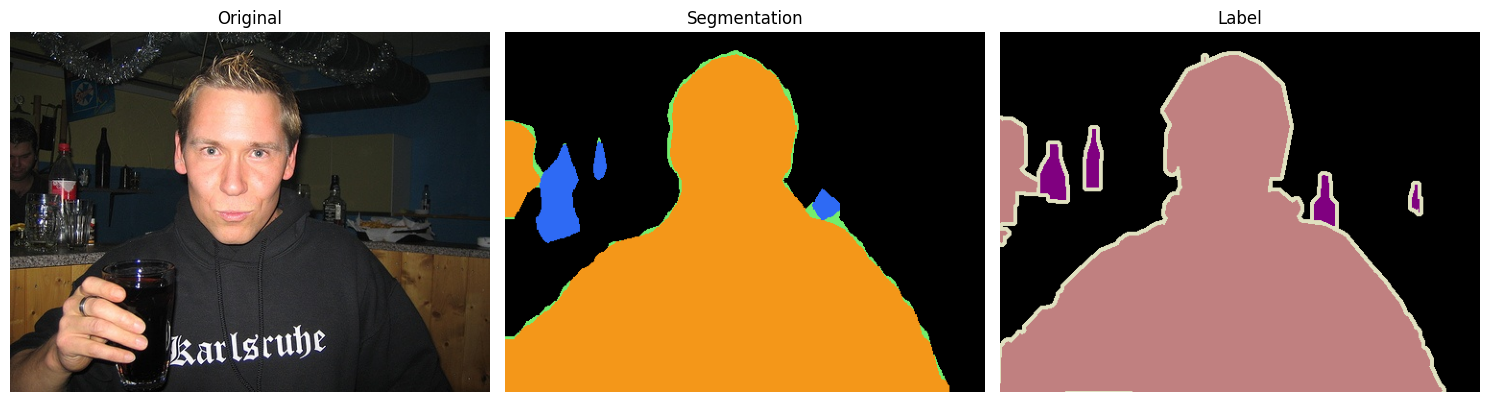

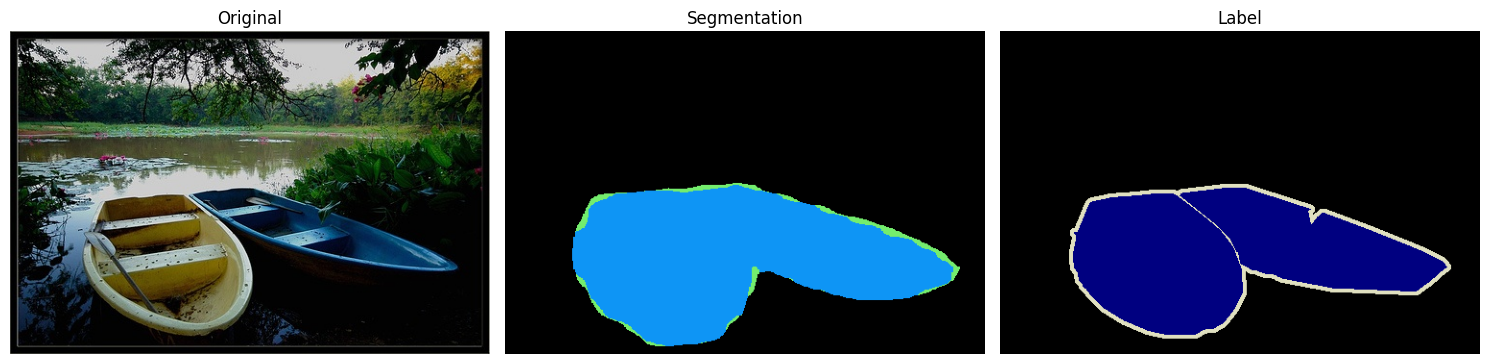

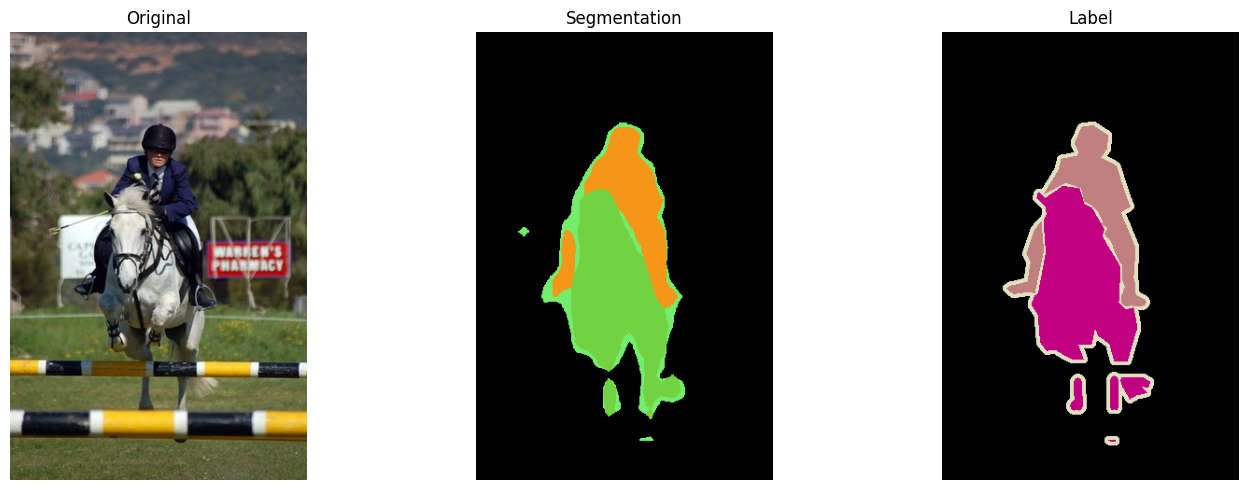

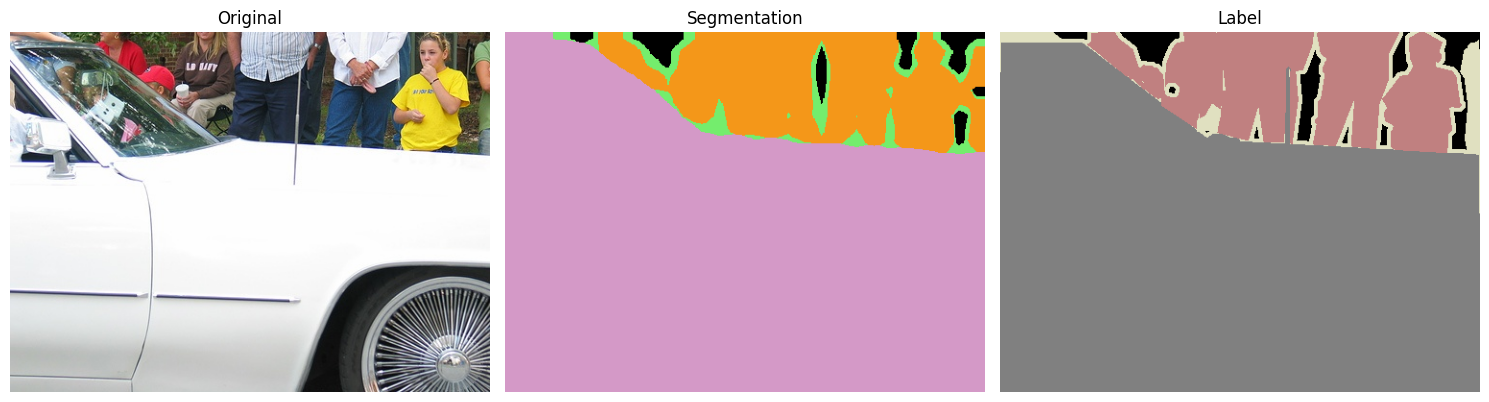

In [16]:
model = load_trained_model(checkpoint_path="/kaggle/working/dinov3_voc_seg_lr0.0001_bs8.pth", backbone_name="facebook/dinov3-vitb16-pretrain-lvd1689m")
images_name = ["2007_000170", "2007_000713", "2007_000836", "2007_001857"]
run_inference(model, images_name=images_name, save_dir='/kaggle/working/output')

In [21]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")

image_size = (IMG_SIZE, IMG_SIZE)
valid_dataset = VOCDataset(
    DATA_ROOT, mode="valid", image_size=image_size, num_classes=NUM_CLASSES
)
valid_loader = DataLoader(
    valid_dataset, batch_size=4, shuffle=False,
    num_workers=4, pin_memory=True
)


In [22]:
model = load_trained_model(checkpoint_path="/kaggle/working/dinov3_voc_seg_lr0.0001_bs2.pth", backbone_name="facebook/dinov3-vitb16-pretrain-lvd1689m")
val_loss, val_miou = validate(
    model, valid_loader, device, num_classes=NUM_CLASSES
)
val_loss, val_miou

Loaded model from /kaggle/working/dinov3_voc_seg_lr0.0001_bs2.pth, best mIoU=0.6141460273554992


(0.23924009370301985, 0.6216205149920682)

In [23]:
model = load_trained_model(checkpoint_path="/kaggle/working/dinov3_voc_seg_lr0.0001_bs4.pth", backbone_name="facebook/dinov3-vitb16-pretrain-lvd1689m")
val_loss, val_miou = validate(
    model, valid_loader, device, num_classes=NUM_CLASSES
)
val_loss, val_miou

Loaded model from /kaggle/working/dinov3_voc_seg_lr0.0001_bs4.pth, best mIoU=0.6459408649168198


(0.2184071989101406, 0.6459408649168198)

In [25]:
model = load_trained_model(checkpoint_path="/kaggle/working/dinov3_voc_seg_lr0.0001_bs8.pth", backbone_name="facebook/dinov3-vitb16-pretrain-lvd1689m")
val_loss, val_miou = validate(
    model, valid_loader, device, num_classes=NUM_CLASSES
)
val_loss, val_miou

Loaded model from /kaggle/working/dinov3_voc_seg_lr0.0001_bs8.pth, best mIoU=0.6592688623424964


(0.2192789741616318, 0.646250491021059)